### Description
* The data shows the sales made in 2019-2020	
* Each line is a sale (Account) with a product (e.g. LPG3) and a loan associated with the product (Total amount = Downpayment + Loan Principal)		
* Cycle indicates how many products the client has bought, 1 means this sale is the first one, 3 means is the third purchase for the same client		
* TRP is a measure of how well the client is paying the loan, see below for definition. TRP stays for "Timely Repayment Percentage" and displays the number of loan installments that have been paid on time, as a percentage of the total number of loan installments that are due.				
* Each client belongs to a Group of at least five members		
* Each loan is a payment plan with a certain number of Installments which are paid monthly		
* Each loan has a start date (Disbursed Date) and a date when it was fully paid (Final Payment Date), hence theoretical end date is Disbursed Date + N monthly Instalments		


### Using the data following points will be investigated:
1. In which order clients that bought more than one product make their purchases? Do they first buy an LPG and then a stove or a solar lamp?		
1. Any correlation/pattern between age of client and choice of product bought?		
1. Repayment behaviour measured with TRP and choice of product bought?		
1. Any correlation/pattern between gender and choice of product bought?		
1. How long do clients really take to fully pay their loans, what is the distribution? Any difference between products?		
1. Of all the products sold which ones would you push more given the historical demand and the repayment behaviour and why?
1. Based on the most relevant features, biuld ML classifier that can predict which clients will pay the loan in time, define the most relevant features. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

In [2]:
# Import dataset
df=pd.read_excel('data.xlsx', sheet_name='Disbursed Loans Report-29-04-20', header=0, nrows=31516)

In [3]:
df.head(3)

,Client ID,Client name,DOB,ID Card,Gender,Account,Branch,Product,Loan Principal,Interest,...,Disbursed Date,Installments,Loan Frequency,Loan Frequency 2,Status,TRP,Group ID,Final Payment Date,Arrear Amount,Days in Arrears
0,0008-0056-17323,NaN,1965-01-01,NaN,Female,18876,Vihiga,BORA,4900,0,...,2019-01-09,7,1,Monthly,Closed,0.714,17073,2019-08-03,0,NaN
1,0008-0056-17324,NaN,1953-05-15,NaN,Female,18877,Vihiga,BORA,4900,0,...,2019-01-09,7,1,Monthly,Closed,1.000,17073,2019-03-12,0,NaN
2,0008-0056-17326,NaN,1954-01-01,NaN,Female,18879,Vihiga,BORA,4900,0,...,2019-01-09,7,1,Monthly,Closed,0.143,17073,2019-08-08,0,NaN


In [4]:
# Count nan for each column
empty_val=df.isna().sum().sort_values(ascending=False)
total_val=df.shape[0]
percent=empty_val/total_val*100
missing_data=pd.concat([empty_val, percent], axis=1, keys=['values', '%'])
print(missing_data)

                    values           %
Client name          31516  100.000000
Days in Arrears      26409   83.795532
ID Card              24851   78.852012
Final Payment Date   12752   40.461988
Cycle                  693    2.198883
TRP                    203    0.644117
DOB                     14    0.044422
Principal                0    0.000000
Gender                   0    0.000000
Account                  0    0.000000
Branch                   0    0.000000
Product                  0    0.000000
Loan Principal           0    0.000000
Interest                 0    0.000000
Down Payment             0    0.000000
Total amount             0    0.000000
Fees                     0    0.000000
Interest.1               0    0.000000
Arrear Amount            0    0.000000
Total                    0    0.000000
Prepayment               0    0.000000
Loan Officer             0    0.000000
Disbursed Date           0    0.000000
Installments             0    0.000000
Loan Frequency           

In [5]:
# Drop Client name, ID Card columns as with too many nan, and Account columns as not relevant for analyses
# Client ID is kept to have a client reference
df=df.drop(["Client name", "ID Card", 'Account'], axis=1)

In [6]:
# Look at the statistics of numerical columns
df.describe()

,Loan Principal,Interest,Down Payment,Total amount,Principal,Interest.1,Fees,Total,Prepayment,Cycle,Installments,Loan Frequency,TRP,Arrear Amount,Days in Arrears
count,31516.000000,31516.0,31516.000000,31516.000000,31516.000000,31516.0,31516.0,31516.000000,31516.000000,30823.000000,31516.000000,31516.0,31313.000000,31516.000000,5107.000000
mean,5086.540170,0.0,879.416804,5965.956974,1150.229217,0.0,0.0,1183.623778,22.262629,1.175778,5.950565,1.0,0.546321,190.488609,65.036225
std,1573.687238,0.0,253.326758,1706.451117,1845.908355,0.0,0.0,1861.169314,292.843960,0.489114,1.742425,0.0,0.373994,618.639452,74.517085
min,2100.000000,0.0,500.000000,2800.000000,0.000000,0.0,0.0,-952.000000,-1850.000000,1.000000,3.000000,1.0,0.000000,0.000000,1.000000
25%,4800.000000,0.0,700.000000,5400.000000,0.000000,0.0,0.0,0.000000,0.000000,1.000000,4.000000,1.0,0.200000,0.000000,10.000000
50%,4900.000000,0.0,900.000000,6000.000000,0.000000,0.0,0.0,0.000000,0.000000,1.000000,6.000000,1.0,0.500000,0.000000,35.000000
75%,5400.000000,0.0,1200.000000,6300.000000,2100.000000,0.0,0.0,2100.000000,0.000000,1.000000,7.000000,1.0,1.000000,0.000000,98.000000
max,13500.000000,0.0,2000.000000,15300.000000,13500.000000,0.0,0.0,13500.000000,6300.000000,8.000000,15.000000,1.0,1.000000,9600.000000,436.000000


In [7]:
# Drop "Interest", "Interest1", "Fees", "Loan Frequency" columns because values do not change along the columns
df=df.drop(["Interest", "Interest.1", "Fees", "Loan Frequency"], axis=1)

In [8]:
df.describe()

,Loan Principal,Down Payment,Total amount,Principal,Total,Prepayment,Cycle,Installments,TRP,Arrear Amount,Days in Arrears
count,31516.000000,31516.000000,31516.000000,31516.000000,31516.000000,31516.000000,30823.000000,31516.000000,31313.000000,31516.000000,5107.000000
mean,5086.540170,879.416804,5965.956974,1150.229217,1183.623778,22.262629,1.175778,5.950565,0.546321,190.488609,65.036225
std,1573.687238,253.326758,1706.451117,1845.908355,1861.169314,292.843960,0.489114,1.742425,0.373994,618.639452,74.517085
min,2100.000000,500.000000,2800.000000,0.000000,-952.000000,-1850.000000,1.000000,3.000000,0.000000,0.000000,1.000000
25%,4800.000000,700.000000,5400.000000,0.000000,0.000000,0.000000,1.000000,4.000000,0.200000,0.000000,10.000000
50%,4900.000000,900.000000,6000.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.500000,0.000000,35.000000
75%,5400.000000,1200.000000,6300.000000,2100.000000,2100.000000,0.000000,1.000000,7.000000,1.000000,0.000000,98.000000
max,13500.000000,2000.000000,15300.000000,13500.000000,13500.000000,6300.000000,8.000000,15.000000,1.000000,9600.000000,436.000000


In [9]:
# Create Age column from DOB column and then drop DOB column
from datetime import datetime
now = pd.to_datetime('now')
df['Age']=now.year-df['DOB'].dt.year
df=df.drop(["DOB"], axis=1)
df.head(10)

,Client ID,Gender,Branch,Product,Loan Principal,Down Payment,Total amount,Principal,Total,Prepayment,...,Disbursed Date,Installments,Loan Frequency 2,Status,TRP,Group ID,Final Payment Date,Arrear Amount,Days in Arrears,Age
0,0008-0056-17323,Female,Vihiga,BORA,4900,700,5600,0,0,0,...,2019-01-09,7,Monthly,Closed,0.714,17073,2019-08-03,0,NaN,55.0
1,0008-0056-17324,Female,Vihiga,BORA,4900,700,5600,0,0,0,...,2019-01-09,7,Monthly,Closed,1.000,17073,2019-03-12,0,NaN,67.0
2,0008-0056-17326,Female,Vihiga,BORA,4900,700,5600,0,0,0,...,2019-01-09,7,Monthly,Closed,0.143,17073,2019-08-08,0,NaN,66.0
3,0008-0056-17327,Female,Vihiga,BORA,4900,700,5600,0,0,0,...,2019-01-09,7,Monthly,Closed,0.143,17073,2019-08-08,0,NaN,34.0
4,0008-0056-17328,Male,Vihiga,BORA,4900,700,5600,0,0,0,...,2019-01-09,7,Monthly,Closed,1.000,17073,2019-08-01,0,NaN,42.0
5,0008-0056-17329,Female,Vihiga,BORA,4900,700,5600,0,0,0,...,2019-01-09,7,Monthly,Closed,0.714,17073,2019-08-08,0,NaN,38.0
6,0008-0058-17318,Female,Vihiga,BORA,4900,700,5600,0,0,0,...,2019-01-09,7,Monthly,Closed,0.286,17109,2019-08-07,0,NaN,74.0
7,0008-0058-17319,Female,Vihiga,BORA,4900,700,5600,0,0,0,...,2019-01-09,7,Monthly,Closed,0.714,17109,2019-08-10,0,NaN,66.0
8,0008-0058-17320,Female,Vihiga,BORA,4900,700,5600,0,0,0,...,2019-01-09,7,Monthly,Closed,1.000,17109,2019-06-08,0,NaN,31.0
9,0008-0058-17321,Male,Vihiga,BORA,4900,700,5600,0,0,0,...,2019-01-09,7,Monthly,Closed,0.143,17109,2019-08-13,0,NaN,23.0


In [10]:
# Check type of the columns
df.dtypes

Client ID                     object
Gender                        object
Branch                        object
Product                       object
Loan Principal                 int64
Down Payment                   int64
Total amount                   int64
Principal                      int64
Total                          int64
Prepayment                     int64
Loan Officer                  object
Cycle                        float64
Disbursed Date        datetime64[ns]
Installments                   int64
Loan Frequency 2              object
Status                        object
TRP                          float64
Group ID                      object
Final Payment Date    datetime64[ns]
Arrear Amount                  int64
Days in Arrears              float64
Age                          float64
dtype: object

In [11]:
# Count unique values in object type columns
unique_values=[df[col].value_counts() for col in df.select_dtypes(include="object").columns]
print(unique_values)

[0004-0044-30635    4
0003-0005-11306    4
0008-0055-23139    3
0006-0066-21328    3
0001-0000-0076     3
                  ..
0009-0063-17805    1
0003-0047-43918    1
0002-0070-19028    1
0008-0057-30176    1
0008-0055-28898    1
Name: Client ID, Length: 29373, dtype: int64, Female    22432
Male       9084
Name: Gender, dtype: int64, Webuye          6402
Siaya           5828
Vihiga          5256
Kapsabet        5032
Moi's Bridge    4194
Mumias          3755
Bomet           1049
Name: Branch, dtype: int64, LPG2    9037
BORA    6028
LPG3    5553
CNVS    3408
BOOM    1192
P400    1192
JIKO    1102
SKH+    1029
COOK     615
CVS2     466
HOME     423
B00M     354
GASC     272
PRO4     240
TNK      194
TANK     173
SPRA     137
SILO      51
MRKT      17
EPC       17
KUNI      11
SLO2       5
Name: Product, dtype: int64,  Job            1212
 Jennifer        899
 Rose            887
 Faith           880
 Emma            879
 Levy            803
 Dennis          760
 Magdalene       754
 Ant

In [12]:
df.columns

Index(['Client ID', 'Gender', 'Branch', 'Product', 'Loan Principal',
       'Down Payment', 'Total amount', 'Principal', 'Total ', 'Prepayment',
       'Loan Officer', 'Cycle', 'Disbursed Date', 'Installments',
       'Loan Frequency 2', 'Status', 'TRP', 'Group ID', 'Final Payment Date',
       'Arrear Amount', 'Days in Arrears', 'Age'],
      dtype='object')

In [13]:
# Drop Loan Frequency 2 column because it has only one value and Group ID column because it is not relevant
df=df.drop(["Loan Frequency 2", "Group ID"], axis=1)
# Total and Principal, Arrears Amount columns duplicate each other
df=df.drop(["Total ", 'Principal'], axis=1)

In [14]:
df.head(10)

,Client ID,Gender,Branch,Product,Loan Principal,Down Payment,Total amount,Prepayment,Loan Officer,Cycle,Disbursed Date,Installments,Status,TRP,Final Payment Date,Arrear Amount,Days in Arrears,Age
0,0008-0056-17323,Female,Vihiga,BORA,4900,700,5600,0,Anthony,1.0,2019-01-09,7,Closed,0.714,2019-08-03,0,NaN,55.0
1,0008-0056-17324,Female,Vihiga,BORA,4900,700,5600,0,Anthony,1.0,2019-01-09,7,Closed,1.000,2019-03-12,0,NaN,67.0
2,0008-0056-17326,Female,Vihiga,BORA,4900,700,5600,0,Anthony,1.0,2019-01-09,7,Closed,0.143,2019-08-08,0,NaN,66.0
3,0008-0056-17327,Female,Vihiga,BORA,4900,700,5600,0,Anthony,1.0,2019-01-09,7,Closed,0.143,2019-08-08,0,NaN,34.0
4,0008-0056-17328,Male,Vihiga,BORA,4900,700,5600,0,Anthony,1.0,2019-01-09,7,Closed,1.000,2019-08-01,0,NaN,42.0
5,0008-0056-17329,Female,Vihiga,BORA,4900,700,5600,0,Anthony,1.0,2019-01-09,7,Closed,0.714,2019-08-08,0,NaN,38.0
6,0008-0058-17318,Female,Vihiga,BORA,4900,700,5600,0,Camelyne,1.0,2019-01-09,7,Closed,0.286,2019-08-07,0,NaN,74.0
7,0008-0058-17319,Female,Vihiga,BORA,4900,700,5600,0,Camelyne,1.0,2019-01-09,7,Closed,0.714,2019-08-10,0,NaN,66.0
8,0008-0058-17320,Female,Vihiga,BORA,4900,700,5600,0,Camelyne,1.0,2019-01-09,7,Closed,1.000,2019-06-08,0,NaN,31.0
9,0008-0058-17321,Male,Vihiga,BORA,4900,700,5600,0,Camelyne,1.0,2019-01-09,7,Closed,0.143,2019-08-13,0,NaN,23.0


In [15]:
from heatmap import heatmap, corrplot

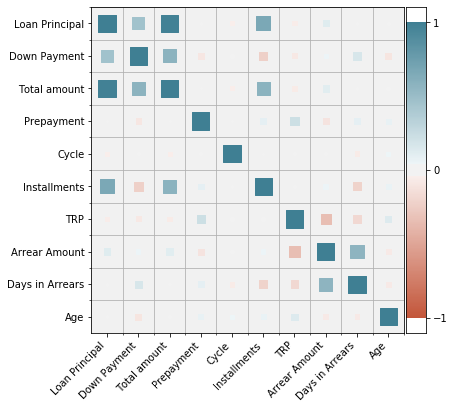

In [16]:
# Check correlations between numerical columns
plt.figure(figsize=(6, 6))
corrplot(df.corr(), size_scale=300)

### In which order clients that bought more than one product make their purchases? Do they first buy an LPG and then a stove or a solar lamp?

In [17]:
# Extract clients ID of clients who purchased >1 products
clients_mult=df["Client ID"].value_counts().to_dict()
clients_mult_idn=[]
for idn, val in clients_mult.items():
    if val>1:
        print(idn)
        clients_mult_idn.append(idn)

0004-0044-30635
0003-0005-11306
0008-0055-23139
0006-0066-21328
0001-0000-0076
0003-0047-20318
0008-0055-17677
0002-0020-24108
0003-0046-21681
0006-0037-27645
0001-0000-0326
0003-0046-21685
0003-0028-20201
0002-0052-19246
0003-0047-25699
0008-0056-17613
0001-0005-3792
0002-0018-22859
0002-0027-15006
0006-0038-26115
0003-0005-10127
0002-0018-18046
0008-0060-19416
0002-0021-18612
0006-0066-21923
0003-0008-13786
0003-0028-20205
0002-0052-18572
0002-0021-23750
0003-0046-11095
0003-0008-11838
0006-0037-9808
0003-0011-17537
0003-0028-20040
0003-0008-11840
0003-0028-23146
0003-0005-19588
0006-0081-25704
0003-0008-18490
0003-0005-21477
0002-0021-8140
0002-0026-8075
0003-0008-15832
0003-0024-24331
0006-0066-30309
0008-0058-20537
0002-0022-9969
0003-0005-18032
0008-0060-19417
0003-0005-25264
0003-0008-11885
0003-0046-27819
0002-0021-18584
0003-0008-14367
0003-0005-17999
0003-0005-17993
0003-0024-18516
0008-0042-11942
0006-0038-24290
0003-0046-11093
0003-0047-25701
0003-0046-18734
0001-0011-2182


In [18]:
products=df["Product"].unique()
print(products)

['BORA' 'LPG2' 'BOOM' 'P400' 'SKH+' 'COOK' 'TANK' 'GASC' 'HOME' 'LPG3'
 'B00M' 'CNVS' 'JIKO' 'MRKT' 'SILO' 'TNK' 'PRO4' 'SPRA' 'SLO2' 'CVS2'
 'KUNI' 'EPC']


In [19]:
# Create column with product groups: "LPG", "Stove", "Solar", "Agricalture"
df['Product_group']=df["Product"]
df.loc[(df["Product"]=="LPG2") | (df["Product"]=="LPG3"), "Product_group"]="LPG"
df.loc[
    (df["Product"]=="BORA") | (df["Product"]=="JIKO") | (df["Product"]=="KUNI") | (df["Product"]=="EPC") | (df["Product"]=="COOK") | (df["Product"]=="GASC"), "Product_group"
]="Stove"
df.loc[(df["Product"]=="B00M") | (df["Product"]=="BOOM") | (df["Product"]=="P400") | (df["Product"]=="PRO4") | (df["Product"]=="HOME") | (df["Product"]=="SKH+"), "Product_group"]="Solar"
df.loc[
    (df["Product"]=="CNVS") | (df["Product"]=="CVS2") | (df["Product"]=="SILO") | (df["Product"]=="SLO2") | (df["Product"]=="SPRA") | (df["Product"]=="TANK") | (df["Product"]=="TNK"), "Product_group"
]="Agricalture"

In [20]:
# Estimate in which order clients buy products 
product_group_list=[df[df['Client ID']==idx]["Product_group"] for idx in clients_mult_idn]

In [21]:
first_product=[]
second_product=[]
third_product=[]
for idx in product_group_list:
    first_product.append(idx.to_list()[0])
    second_product.append(idx.to_list()[1])
    if len(idx)>2:
        third_product.append(idx.to_list()[2])

In [22]:
from collections import Counter
print("Absolute number of the first product sold:")
print(Counter(first_product).keys())
print(Counter(first_product).values())
print("Absolute number of the second product sold:")
print(Counter(second_product).keys())
print(Counter(second_product).values())
print("Absolute number of the third product sold:")
print(Counter(third_product).keys())
print(Counter(third_product).values())

Absolute number of the first product sold:
dict_keys(['Stove', 'LPG', 'Solar', 'Agricalture', 'MRKT'])
dict_values([505, 1038, 341, 154, 1])
Absolute number of the second product sold:
dict_keys(['Agricalture', 'LPG', 'Stove', 'Solar', 'MRKT'])
dict_values([584, 436, 613, 405, 1])
Absolute number of the third product sold:
dict_keys(['Agricalture', 'LPG', 'Solar', 'Stove'])
dict_values([32, 18, 25, 27])


### Distrubution of groups of products for clients who purchase more than one product
#### First product purchased

|LPG|Stove|Solar|Agricalture|
|-|-|-|-|
|1038|505|341|154|

#### Second products purchased:

|Stove|Agricalture|LPG|SOlar|
|-|-|-|-|
|613|584|436|405|

#### Third products purchased:

|Agricalture|Stove|Solar|LPG|
|-|-|-|-|
|32|27|25|18|

Text(0, 0.5, 'Age')

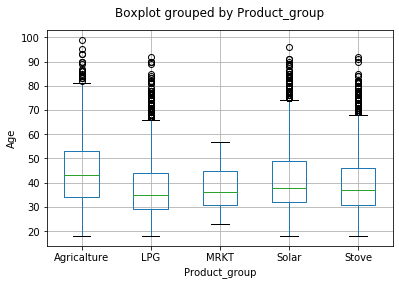

In [23]:
df.boxplot(column = 'Age', by = 'Product_group');
plt.title('')
plt.ylabel("Age")

### There is a clear trend that older people more likely buy agricalture products.

|Product group|LPG|Stove|Agrecalture|Solar|
|-|-|-|-|-|
|Mean age|35|37|43|38|

Text(0, 0.5, 'TRP')

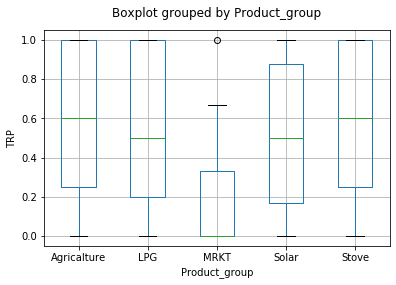

In [24]:
df.boxplot(column = 'TRP', by = 'Product_group');
plt.title('')
plt.ylabel("TRP")

### Agricalture and Stove products are puchased better compare to LPG and Solar. Possibly correlated with age

|Product group|LPG|Stove|Agrecalture|Solar|
|-|-|-|-|-|
|TRP (%)|50|60|60|50|

In [25]:
# Estimating correlation between categorical features Product_group and Gender using pandas crosstab method
x_tab_product_age=pd.crosstab(df["Product_group"], df["Gender"])
x_tab_product_age["Male"]=x_tab_product_age["Male"]/x_tab_product_age["Male"].sum()
x_tab_product_age["Female"]=x_tab_product_age["Female"]/x_tab_product_age["Female"].sum()

### There is a correlation between group of product and gender of the client: mens buy more often LPG and much less often Stoves compare to women. However LPG and Stoves are the most popular products for both genders. 

In [26]:
x_tab_product_age.head()

Gender,Female,Male
Product_group,,
Agricalture,0.145908,0.127807
LPG,0.423056,0.561427
MRKT,0.000713,0.000110
Solar,0.136279,0.151145
Stove,0.294044,0.159511


In [27]:
df.columns

Index(['Client ID', 'Gender', 'Branch', 'Product', 'Loan Principal',
       'Down Payment', 'Total amount', 'Prepayment', 'Loan Officer', 'Cycle',
       'Disbursed Date', 'Installments', 'Status', 'TRP', 'Final Payment Date',
       'Arrear Amount', 'Days in Arrears', 'Age', 'Product_group'],
      dtype='object')

In [28]:
df["Duration of loan"]=df['Final Payment Date']-df['Disbursed Date']

In [29]:
df["Duration of loan"]=df["Duration of loan"].dt.days

### Distrubution of the time that clients take to fully pay their loans for each product category are shown below:

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

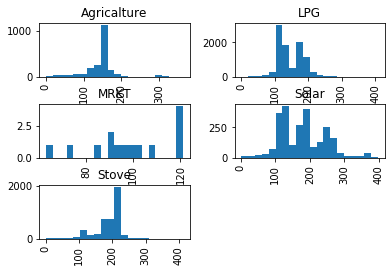

In [30]:
# Plot histogram of product groups sales distribution 
%matplotlib inline
df.hist(column="Duration of loan", bins=20, by="Product_group")
plt.plot

In [31]:
# Check statistic for each product groupd category to extract mean payment period
grouped=df.groupby('Product_group')

In [32]:
grouped.describe()['Duration of loan']

,count,mean,std,min,25%,50%,75%,max
Product_group,,,,,,,,
Agricalture,2145.0,144.831702,45.567781,1.0,135.00,151.0,155.0,363.0
LPG,9526.0,147.056477,40.269491,0.0,120.00,130.0,182.0,409.0
MRKT,14.0,98.571429,17.973118,63.0,90.25,97.5,116.0,121.0
Solar,2486.0,177.346340,67.232851,2.0,122.00,178.0,234.0,398.0
Stove,4593.0,189.082952,43.394871,1.0,178.00,205.0,213.0,412.0


### Stove product has the longest average payment period (189 days). The shortest is with Agricaltural and LPG products (144 and 147 days). 


|Product group|LPG|Stove|Agrecalture|Solar|
|-|-|-|-|-|
|Average payment period (days)|147|189|144|177|

In [33]:
# Calculating the ratio of the loans not paid in time to the total amount of loans for each product category
status_dict=grouped['Status'].value_counts().to_dict()

In [34]:
product_gropus_status_counts=grouped['Status'].count().to_dict()

In [35]:
ratio_agricalture=status_dict['Agricalture', 'Overdue']/product_gropus_status_counts['Agricalture']
ratio_LPG=status_dict['LPG', 'Overdue']/product_gropus_status_counts['LPG']
ratio_Solar=status_dict['Solar', 'Overdue']/product_gropus_status_counts['Solar']
ratio_Stove=status_dict['Stove', 'Overdue']/product_gropus_status_counts['Stove']

In [36]:
print("Fraction of overdue loans for agricaltural products:")
print(ratio_agricalture)
print("Fraction of overdue loans for LPG:")
print(ratio_LPG)
print("Fraction of overdue loans for solar products:")
print(ratio_Solar)
print("Fraction of overdue loans for Stoves:")
print(ratio_Stove)

Fraction of overdue loans for agricaltural products:
0.16689219666215607
Fraction of overdue loans for LPG:
0.1608636052090473
Fraction of overdue loans for solar products:
0.19367945823927765
Fraction of overdue loans for Stoves:
0.14356743318831572


### Customers, who buy stoves, show the best payment behavior, fraction of overdue payments are 14%.  Solar product category are paid the least carefully, with fraction of overdue payments of 19%.
### LPG category has to pushed for sales. It is of very high demand (50% of the all products sold), has short payment period and low number of overdue payments. 
### Stoves is the next product category that should be pushed. Despite the longest payment period, it has low fraction of overdue payments and relatevely high demand of 25%

### Now a simple  classifier will be built to predict which clients will pay the loan in time. To do this, the separate cleaned and filtered dataset will be created

In [37]:
# Create binary dependent feature "Not_paid", where 1 - loan payment is overdue
df_ml_model=df.loc[(df["Status"]=="Closed") | (df["Status"]=="Overdue")].copy()
df_ml_model["Not_paid"]=0
df_ml_model.loc[(df_ml_model["Status"]=="Overdue"), "Not_paid"]=1
df_ml_model.loc[(df_ml_model["Status"]=="Closed"), "Not_paid"]=0
df_ml_model["Not_paid"]=pd.to_numeric(df_ml_model["Not_paid"])

In [38]:
df_ml_model.head(10)

,Client ID,Gender,Branch,Product,Loan Principal,Down Payment,Total amount,Prepayment,Loan Officer,Cycle,...,Installments,Status,TRP,Final Payment Date,Arrear Amount,Days in Arrears,Age,Product_group,Duration of loan,Not_paid
0,0008-0056-17323,Female,Vihiga,BORA,4900,700,5600,0,Anthony,1.0,...,7,Closed,0.714,2019-08-03,0,NaN,55.0,Stove,206.0,0
1,0008-0056-17324,Female,Vihiga,BORA,4900,700,5600,0,Anthony,1.0,...,7,Closed,1.000,2019-03-12,0,NaN,67.0,Stove,62.0,0
2,0008-0056-17326,Female,Vihiga,BORA,4900,700,5600,0,Anthony,1.0,...,7,Closed,0.143,2019-08-08,0,NaN,66.0,Stove,211.0,0
3,0008-0056-17327,Female,Vihiga,BORA,4900,700,5600,0,Anthony,1.0,...,7,Closed,0.143,2019-08-08,0,NaN,34.0,Stove,211.0,0
4,0008-0056-17328,Male,Vihiga,BORA,4900,700,5600,0,Anthony,1.0,...,7,Closed,1.000,2019-08-01,0,NaN,42.0,Stove,204.0,0
5,0008-0056-17329,Female,Vihiga,BORA,4900,700,5600,0,Anthony,1.0,...,7,Closed,0.714,2019-08-08,0,NaN,38.0,Stove,211.0,0
6,0008-0058-17318,Female,Vihiga,BORA,4900,700,5600,0,Camelyne,1.0,...,7,Closed,0.286,2019-08-07,0,NaN,74.0,Stove,210.0,0
7,0008-0058-17319,Female,Vihiga,BORA,4900,700,5600,0,Camelyne,1.0,...,7,Closed,0.714,2019-08-10,0,NaN,66.0,Stove,213.0,0
8,0008-0058-17320,Female,Vihiga,BORA,4900,700,5600,0,Camelyne,1.0,...,7,Closed,1.000,2019-06-08,0,NaN,31.0,Stove,150.0,0
9,0008-0058-17321,Male,Vihiga,BORA,4900,700,5600,0,Camelyne,1.0,...,7,Closed,0.143,2019-08-13,0,NaN,23.0,Stove,216.0,0


In [39]:
# Drop columns which are not relevant for classification problem
df_ml_model.drop(
    ["Client ID", "Product",
    "Loan Officer", "Status", "Disbursed Date", "Final Payment Date", 'Branch', 'Loan Principal', 'Down Payment', 'Duration of loan', 'Days in Arrears', 'Arrear Amount'], axis=1, inplace=True)

In [40]:
# Fill NaN values
df_ml_model["Cycle"].fillna(1, inplace=True)
df_ml_model["Age"].fillna(np.mean(df_ml_model['Age']), inplace=True)
df_ml_model["TRP"].fillna(np.mean(df_ml_model['TRP']), inplace=True)

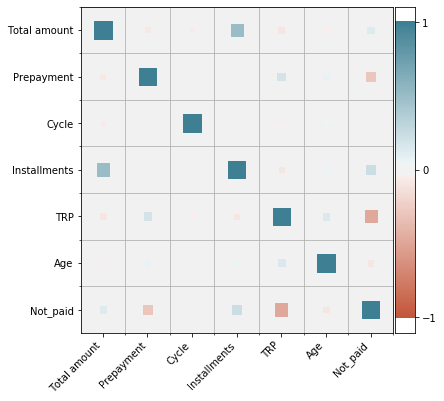

In [41]:
# Check correlations between numerical features and dependent variable 
plt.figure(figsize=(6, 6))
corrplot(df_ml_model.corr(), size_scale=300)

In [42]:
# Convert categorical features to dummy variables
df_ml_model_dummies=pd.get_dummies(data=df_ml_model, drop_first=True)

In [43]:
# Create dependent variable
Y=df_ml_model_dummies['Not_paid']

In [44]:
X=df_ml_model_dummies.drop(['Not_paid'], axis=1)
X.head()

,Total amount,Prepayment,Cycle,Installments,TRP,Age,Gender_Male,Product_group_LPG,Product_group_MRKT,Product_group_Solar,Product_group_Stove
0,5600,0,1.0,7,0.714,55.0,0,0,0,0,1
1,5600,0,1.0,7,1.000,67.0,0,0,0,0,1
2,5600,0,1.0,7,0.143,66.0,0,0,0,0,1
3,5600,0,1.0,7,0.143,34.0,0,0,0,0,1
4,5600,0,1.0,7,1.000,42.0,1,0,0,0,1


In [45]:
# Split dataset to train and test datasets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test=train_test_split(X, Y, test_size=0.2, random_state=0)

In [46]:
# Chhosing Random Forest Classifier. Scaling of data is not necessary for this type of classifier 
from sklearn.ensemble import RandomForestClassifier
regr=RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0, max_features='sqrt')
regr.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [47]:
Y_predict=regr.predict(X_test)

In [48]:
# Checking the metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
cm=confusion_matrix(Y_test, Y_predict)
f1=f1_score(Y_test, Y_predict)
print(cm)
print(f1)

[[3522  184]
 [ 349  665]]
0.7139023081052066


### Confusion matrix and f1 score shows not the best performance. However 2/3 of the "not paid" loans are predicted

In [49]:
# Checking cross vlidation score
from sklearn.model_selection import cross_val_score
scores=cross_val_score(regr, X_train, Y_train, cv=10, scoring="accuracy")
print(scores)

In [51]:
# Check feature importance
regr.feature_importances_

array([4.37941421e-02, 2.85524007e-01, 2.04035011e-02, 6.35681101e-02,
       3.60234538e-01, 1.93336017e-01, 1.26061877e-02, 4.98920083e-03,
       2.03131269e-04, 7.72483547e-03, 7.61632929e-03])

|Feature|TRP|Prepayment|Age|Installment|Total Amount|Cycle|Product Group|Gender|
|-|-|-|-|-|-|-|-|-|
|Feature importance (%)|36|28.6|19.3|6.4|4.4|2|2|1.3|

### The most important feature is the payment history of TRP, followed by prepayment amount and Age

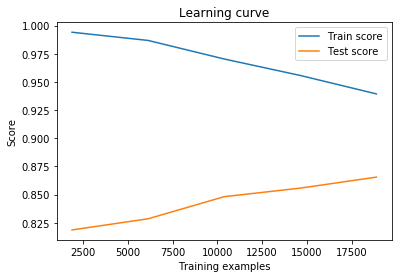

In [52]:
# Plotting learning curve
from sklearn.model_selection import learning_curve
tr_size, train_scores_learn_curve, test_scores_learn_curve=learning_curve(regr, X, Y, n_jobs=-1)
train_scores_learn_curve=np.mean(train_scores_learn_curve, axis=1)
test_scores_learn_curve=np.mean(test_scores_learn_curve, axis=1)
# Plot learning curve
fig1, ax1=plt.subplots()
ax1.plot(tr_size, train_scores_learn_curve, label="Train score")
ax1.plot(tr_size, test_scores_learn_curve, label="Test score")
plt.title("Learning curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend()
plt.show()

### Learning curve behaviour suggests that increasing number of observations can help improve accuracy of the model